# Forecasting Dst & dDst

In this notebook, I first develop an advanced GRU approach to model Dst index during storm events and tested by an independent storm (Kfolds=60). The uncertainty of Dst (hereinafter called `dDst') is then modeled by a vanilla MLP model and the ACCURE method (https://ml-space-weather.github.io/papers/IJUQ1104(5)-34623.pdf). Finally, we assimilate the predicted dDst into the predicted Dst via Kalman filter. 

Solar wind data come from the OMNI dataset, and geomagnetic field measurements come from SuperMAG.

## Omni Download


In [ ]:
############################## 
from datetime import datetime
from heliopy.data.omni import h0_mrg1hr

t0 = [2000, 1, 1]
t1 = [2022, 2, 10]
filename = 'Data/omni_data.pkl'

# Set the start and end date as year, month, day
t0 = datetime(*t0)
t1 = datetime(*t1)

# Download the data
ts = h0_mrg1hr(t0, t1)

# Extract dataframe
df = ts.to_dataframe()

# Save data so it can be loaded later
df.to_pickle(filename)

The data span of Omni data is from 0:00 January 1, 1998 to 23:00 December 31, 2017, UT. 

Then we select those storm events whose peak Dst is <-100 nT.

The next cell is a list of configurations used here

In [16]:
from cProfile import label
import pandas as pd
import numpy as np
import h5py
from multiprocessing import cpu_count, Pool
import time
from tqdm import tqdm
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import rc

from nets import CNN_1D, lstm_reg, lstm_gp, my_weight_rmse_CB
from nets import cdf_AH, norm_cdf
from nets import seed_torch, init_weights, PhysinformedNet, my_custom_loss_func

import torch
from torch.optim import Adam, AdamW, RMSprop
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import ProgressBar, Checkpoint
from skorch.callbacks import EarlyStopping, WarmRestartLR, LRScheduler
import sklearn
from sklearn.metrics import make_scorer

from funs import smooth, stretch, est_beta, train_Dst, train_std_GRU
from funs import train_std, QQ_plot, visualize, storm_sel_omni, storm_sel_ACE

from ipdb import set_trace as st

######################## configuration ####################
delay = 6 # predict how many hours ahead
Dst_sel = -100 # threshold for strong storms
storm_idx = [27] # index of test storm (27 is the 2003-Halloween storm)
img_format = 'jpg' # format of saved images
width = 3 # width for smoothing the Kyoto Dst index
std_method = 'GRU' # std model arichtecture ('MLP' or 'GRU') 
DA_method = 'Linear' # data assimilation method ('DA' or 'KF_std')
device_num = 1 # which cuda to use (0-7 on Alfven, >=10 means cpu)
if device_num >= 10:
    device = torch.device("cpu")
else:
    device = torch.device("cuda:"+str(device_num)) 
print(device)
ratio = 1.1 # ratio of strech the Dst during the main phase
vari = [0, 1, 2, 3, 4, 5, 6, 7] 
## all variables are used
'''
0: IMF electron density(N)
1: IMF electron velocity(V)
2: IMF B_norm(i.e., sqrt(Bx**2+By**2+Bz**2))
3: IMF Bz
4: F10.7 one day ago
5: dipole tilt angle:
t_year = 23.4*np.cos((DOY-172)*2*pi/365.25)
t_day = 11.2*np.cos((UTC-16.72)*2*pi/24)
t = t_year+t_day

6: sin of clock angle: sin(arctan(IMF By, IMF Bz))
7: Dst
'''
Omni_data = 'Data/Omni_data.pkl' # saved Omni data
pred = 'GRU' # Dst pred model
pred_flag = 1 # if the Dst model residual used for dDst model 
Dst_model = 0 # if retrain the Dst model
std_model = 0 # if retrain the dDst model
iter_mode = 1 # if iteration method is used for DA
qq_plot = 1 # if QQ test result will be tested
visual_flag = 1 # if save the visualization results

# prediction from (t-1)hr ahead when prediting (t)hr ahead 
filename_load = 'Res/Uncertainty_'+\
    str(delay-1)+'-' +\
    str(Dst_sel)+'-'+'.h5'

# prediction from (t)hr ahead model
filename_save = 'Res/Uncertainty_'+\
    str(delay)+'-' +\
    str(Dst_sel)+'-'+'.h5'

# QQ-plots: Quantile-Quantile plots
figname_QQ = 'Figs/calibrate_UQ2_'+\
    str(delay)+'-' +\
    str(Dst_sel)+'-'+\
    str(storm_idx[0])+'-'+\
    pred+'.'+img_format 

# prediction results
figname_pred = 'Figs/predict_UQ2_'+\
    str(delay)+'-' +\
    str(Dst_sel)+'-'+\
    str(storm_idx[0])+'.'+img_format  

# fonts in figures
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 22}

# implement figures
rc('font', **font)

cuda:1


In [29]:
######################## storm select ####################

if width == 0:
    pass
else:
    # meanwhile, smooth Dst
    storm_sel_omni(Omni_data, delay, Dst_sel, width) 
    # storm_sel_ACE(Omni_data, delay, Dst_sel, width, 60) 


Missing value count N            4532
V             347
BX_GSE        224
BY_GSE        224
BZ_GSE        224
F10_INDEX     266
DST             0
dtype: int64/192884
Missing value count N            0
V            0
BX_GSE       0
BY_GSE       0
BZ_GSE       0
F10_INDEX    0
DST          0
dtype: int64/192884


























































































































































































































































































































100%|██████████| 192872/192872 [00:02<00:00, 76869.85it/s]
















































































































































100%|██████████| 192872/192872 [00:01<00:00, 170277.41it/s]


0 & 2000-02-04 06:00:00 & 2000-02-20 00:00:00 & -114.33333333333334
1 & 2000-03-30 23:00:00 & 2000-04-13 07:00:00 & -283.0
2 & 2000-05-22 13:00:00 & 2000-06-03 03:00:00 & -139.00000000000003
3 & 2000-07-13 06:00:00 & 2000-07-20 05:00:00 & -293.33333333333337
4 & 2000-08-08 15:00:00 & 2000-08-19 19:00:00 & -220.33333333333337
5 & 2000-09-16 07:00:00 & 2000-09-25 02:00:00 & -192.00000000000003
6 & 2000-09-23 05:00:00 & 2000-10-13 10:00:00 & -170.66666666666669
7 & 2000-11-02 16:00:00 & 2000-11-16 02:00:00 & -147.33333333333334
8 & 2000-11-25 07:00:00 & 2000-12-06 06:00:00 & -110.33333333333334
9 & 2001-03-16 10:00:00 & 2001-03-27 14:00:00 & -143.66666666666669
10 & 2001-03-29 15:00:00 & 2001-04-05 03:00:00 & -361.33333333333337
11 & 2001-04-07 00:00:00 & 2001-04-22 04:00:00 & -240.66666666666669
12 & 2001-09-24 09:00:00 & 2001-10-08 03:00:00 & -158.66666666666669
13 & 2001-10-17 21:00:00 & 2001-10-25 22:00:00 & -183.66666666666669
14 & 2001-11-04 06:00:00 & 2001-11-15 15:00:00 & -287.000

Overall, there are 60 storms. A cross-validation method with a Kfold=60 is applied. That means we train a model by using 66 storms and tested by the other storm every round. Each storm can be selected as the test set once and once only. Here lists an example of the 2003-Halloween storm.

## Dst modeling using GRU method

In [17]:
######################## model Dst ####################

test_idx_clu = [0]
train_idx_clu = [0]

score = make_scorer(my_custom_loss_func,
                    greater_is_better=False)

with h5py.File('Data/data_'+str(delay)+
               '_'+str(Dst_sel)+'.h5', 'r') as f:

    idx = list(range(np.array(f['num'])))

    # print(f.keys())
    print(f['X_DL_{}'.format(idx[0])].shape)
    print(f['Y_DL_{}'.format(idx[0])].shape)
    print(f['Dst_Per{}'.format(idx[1])].shape)
    # st()
    # train
    X_train = np.array(f['X_DL_{}'.format(idx[0])][:, :, vari])
    Y_train = np.array(f['Y_DL_{}'.format(idx[0])])      
    Dst_Per = np.array(f['Dst_Per{}'.format(idx[0])])        

    for i in tqdm(range(1, len(idx))):
        # import ipdb;ipdb.set_trace()
        train_idx_clu.append(len(Y_train))
        X_train = np.vstack([X_train, \
            np.array(f['X_DL_{}'.format(idx[i])][:, :, vari])
            ])
        Y_train = np.vstack([Y_train, \
            np.array(f['Y_DL_{}'.format(idx[i])])
            ])
        Dst_Per = np.hstack((Dst_Per, \
            np.array(f['Dst_Per{}'.format(idx[i])])
            ))
    train_idx_clu.append(len(Y_train))

    # test
    X_test = np.array(f['X_DL_{}'.format(storm_idx[0])][:, :, vari])
    Y_test = np.array(f['Y_DL_{}'.format(storm_idx[0])])
    Dst_Per_t = np.array(f['Dst_Per{}'.format(storm_idx[0])])
    date_test = np.array(f['date_DL_{}'.format(storm_idx[0])])

    for i in tqdm(range(1, len(storm_idx))):
    
        test_idx_clu.append(len(Y_test))
        X_test = np.vstack([X_test,\
            np.array(f['X_DL_{}'.format(storm_idx[i])])
            ])
        Y_test = np.vstack([Y_test,\
            np.array(f['Y_DL_{}'.format(storm_idx[i])])
            ])
        Dst_Per_t = np.vstack([Dst_Per,\
            np.array(f['Dst_Per{}'.format(storm_idx[i])])
            ])
            
    test_idx_clu.append(len(Y_test))
    
    f.close()

if (delay > 1) & iter_mode:
    with h5py.File(filename_load, 'r') as f:
        # st()
        Dst_Per = np.array(f['y'+str(storm_idx[0])]) 
        Dst_Per_t = np.array(f['y_t'+str(storm_idx[0])]) 
        std_Per = np.array(f['std'+str(storm_idx[0])]) 
        std_Per_t = np.array(f['std_t'+str(storm_idx[0])]) 
        print(f['y{}'.format(storm_idx[0])].shape)
        print(f['std{}'.format(storm_idx[0])].shape)
        f.close()

X = X_train
X[:, :, -6:] = stretch(X[:, :, -6:], ratio=ratio, thres=Dst_sel)
Y = stretch(Y_train, ratio=ratio, thres=Dst_sel)

# print(X[:, -1, :].max(axis=0))
# print(Y[:, -1].max())

# print(X_test[:3, -1, :].max(axis=0))
# print(Y_test[:10, -1])
# print(Dst_Per_t[:10])
# Y = Y_train
# st()

X_t = X_test
Y_t = Y_test  

# st()
y_Per = stretch(Dst_Per, ratio=ratio, thres=Dst_sel)
y_Per_t = Dst_Per_t

if storm_idx[0] == 27:
    date_idx = np.arange(264, 360)
else:
    date_idx = np.arange(6, Y_t.shape[0]-6)
'''
date_idx = np.arange(6, Y_t.shape[0]-6)
'''

############################ model 
y_pred = train_Dst(X, Y, X, delay, Dst_sel, 
                   storm_idx[0], Dst_model)
y_pred_t = train_Dst(X, Y, X_t, delay, Dst_sel, 
                     storm_idx[0], False)

print('max of y_pred_t {}'.format(y_pred_t.max()))
print('min of y_pred_t {}'.format(y_pred_t.min()))

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.plot(y_pred_t[:100, -1].squeeze(), 'b.-', label='GRU')
# ax.plot(Y_t[:100, -1].squeeze(), 'm.-', label='real')
# fig.savefig('Figs/test.jpg')
# plt.close()








100%|██████████| 58/58 [00:00<00:00, 1185.21it/s]







0it [00:00, ?it/s]

(378, 6, 8)
(378, 6, 1)
(320,)
(18173,)
(18173,)


max of y_pred_t 16.511798858642578
min of y_pred_t -433.9739990234375


## dDst modeling using ACCURE method








96it [00:00, 460701.58it/s]


CRPS_min: 5.059749811259512, RS_min: 0.3989422819712232
CRPS_min: 2.787991050789653, RS_min: 0.3989422819712232


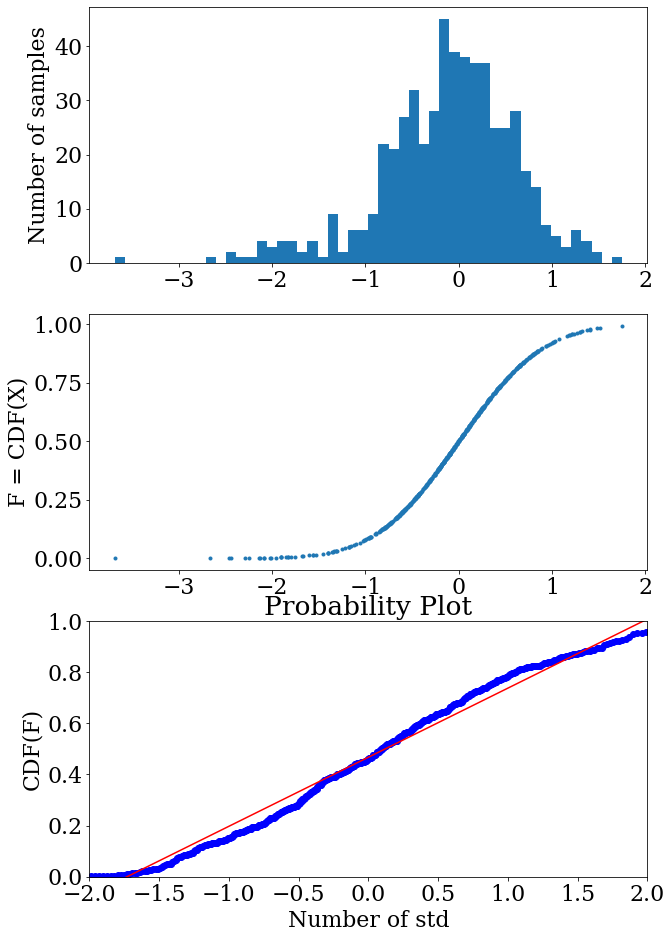

In [18]:
######################## model dDst ####################

date_clu = []
for i, date_tt in tqdm(enumerate(date_test[date_idx])):
            
    t = dt.datetime(int(date_tt[0]),
                    int(date_tt[1]),
                    int(date_tt[2]),
                    int(date_tt[3]),
                    )
    date_clu.append(t) 
    
y_real = Y_train[:, -1].squeeze()
y_real_t = Y_t[:, -1].squeeze()

# preprocess
y = y_pred[:, -1].squeeze()
y_t = y_pred_t[:, -1].squeeze()
x = X[:, -1, :].reshape([X.shape[0], -1]).squeeze()
x_t = X_t[:, -1, :].reshape([X_t.shape[0], -1]).squeeze()
# x = X[:, -1, :].squeeze()
# x_t = X_t[:, -1, :].squeeze()

if pred_flag:
    x = np.vstack([x.T, y.T-y_real.T]).T
    x_t = np.vstack([x_t.T, y_t.T-y_real_t.T]).T

# dd = y - y_real
# print(dd.shape)
# print('d_max is: {}'.format(dd.max()))
# print('d_min is: {}'.format(dd.min()))

if std_method == 'MLP':
    std_Y = train_std(x, x_t, y, y_real, delay, Dst_sel, 
                    storm_idx[0], device,
                    pred='gru', 
                    train=std_model,
                    #   train=False
                    )

elif std_method == 'GRU':
    std_Y = train_std_GRU(X, X_t, y_pred, Y_train, delay, 
                          Dst_sel, 
                          storm_idx[0], 
                          device,
                          pred='gru', 
                          train=std_model,
                        #   train=False
                          )

std_Y_per = train_std(x, x_t, y_Per, y_real, delay, Dst_sel, 
                    storm_idx[0], device, 
                    pred='per', 
                    train=std_model,
                    # train=False
                    )

# print(std_Y_per.max())
# print(std_Y_per.min())

# st()

if qq_plot:
    QQ_plot(y_real_t, y_t, std_Y, figname_QQ)

The above figures show the distribution of the GRU residuals. X axis is Resi/std.

Top panel is the PDF of residuals (X), middle panel is the cdf of residuals (F) and bottom panel is CDF(F).

Similar to quantile-quantile plot, this plot is used to check if the residuals are in a normal distribution.

## Improve Dst predictions from the GRU predictions and the dDst via KF

After dDst and Dst are obtained, KF is used to assimilate dDst into Dst to further improve the model accuracy.

In [19]:
########################### KF part ############################

y_t_clu = []
name_clu = []
color_clu = []

if 'Linear' in DA_method:

    ########################### Linear estimator part 
    y_tr = y_pred[:, -1].squeeze()
    y_t = y_pred_t[:, -1].squeeze()

    std_Y_per_train = train_std(x, x, y_Per, y_real, 
                    delay, Dst_sel, 
                    storm_idx[0], 
                    device,
                    pred='per', 
                    train=False)
    if std_method == 'GRU':
        std_Y_train = train_std_GRU(X, X, y_pred, Y_train, delay, 
                            Dst_sel, 
                            storm_idx[0], 
                            device,
                            pred='gru', 
                            train=False,
                            #   train=False
                            )
    else:
        std_Y_train = train_std(x, x, y, y_real, delay, Dst_sel, 
                        storm_idx[0],
                        device,
                        pred='gru', 
                        train=False)

    sigma_per_train = std_Y_per_train**2
    sigma_GRU_train = std_Y_train**2
    sigma_per = std_Y_per**2
    sigma_GRU = std_Y**2

    y_tr = sigma_per_train/(sigma_per_train+sigma_GRU_train)*y_tr+\
        sigma_GRU_train/(sigma_per_train+sigma_GRU_train)*y_Per

    y_t = sigma_per/(sigma_per+sigma_GRU)*y_t+\
        sigma_GRU/(sigma_per+sigma_GRU)*y_Per_t

    std_train = 1/(1/sigma_per_train + 1/sigma_GRU_train) # need to modify
    std_test = 1/(1/sigma_per + 1/sigma_GRU) # need to modify

    y_t_clu.append(y_t)
    name_clu.append('Linear')
    color_clu.append('g')

if 'KF_std' in DA_method:

    ################# with std ###########
    y_KF1 = np.array(y_pred_t[:, -1])
    P = 1/21
    Q = 1/16
    R = 1/16

    for idx, y in tqdm(enumerate(y_Per_t)):
        if y > Dst_sel:
            continue
        P = P+Q
        Resi = y - y_pred_t[idx, -1]
        K = P/(P+R)
        y_KF1[idx] = y_KF1[idx] + K*Resi
        P = (1-K)*P
        Q = std_Y[idx]**2
        R = std_Y_per[idx]**2
    
    y_t_clu.append(y_KF1)
    name_clu.append('KF_std')
    color_clu.append('m')

if 'KF_real' in DA_method:

    ################# with std ###########
    y_KF2 = np.array(y_pred_t[:, -1])
    P = 1/21
    Q = 1/16
    R = 1/16

    for idx, y in tqdm(enumerate(y_Per_t)):
        if y > Dst_sel:
            continue
        P = P+Q
        Resi = y - y_pred_t[idx, -1]
        K = P/(P+R)
        y_KF2[idx] = y_KF2[idx] + K*Resi
        P = (1-K)*P
        Q = Resi**2
        R = (y_real_t[idx-2*delay] - y_real_t[idx-delay])**2

    y_t_clu.append(y_KF2)
    name_clu.append('KF_real')
    color_clu.append('k')

# print('RMSE of training: {}'.format(np.mean((y-y_real)**2)))
# print('RMSE of test: {}'.format(np.mean((y_t-y_real_t)**2)))

with h5py.File(filename_save, 'a') as f:

    for w in ['y'+str(storm_idx[0]),
              'std'+str(storm_idx[0]),
              'y_t'+str(storm_idx[0]),
              'std_t'+str(storm_idx[0]),
              'y_gru'+str(storm_idx[0]),
              'y_gru_t'+str(storm_idx[0]),
                ]:
        if w in f:
            del f[w]
    # st()
    
    f.create_dataset('y'+str(storm_idx[0]),
                        data = y_tr.squeeze())
    f.create_dataset('std'+str(storm_idx[0]),
                        data = std_train.squeeze())
    f.create_dataset('y_t'+str(storm_idx[0]),
                        data = y_t.squeeze())
    f.create_dataset('std_t'+str(storm_idx[0]),
                        data = std_test.squeeze())
    f.create_dataset('y_gru'+str(storm_idx[0]),
                        data = y_pred[:, -1].squeeze())
    f.create_dataset('y_gru_t'+str(storm_idx[0]),
                        data = y_pred_t[:, -1].squeeze())
    f.close()

CRPS_min: 2.787991050789653, RS_min: 0.3989422819712232
CRPS_min: 5.059749811259512, RS_min: 0.3989422819712232


## Visualize of the final Dst predictions

start date: 2003-11-19 05:00:00
end date: 2003-11-23 04:00:00


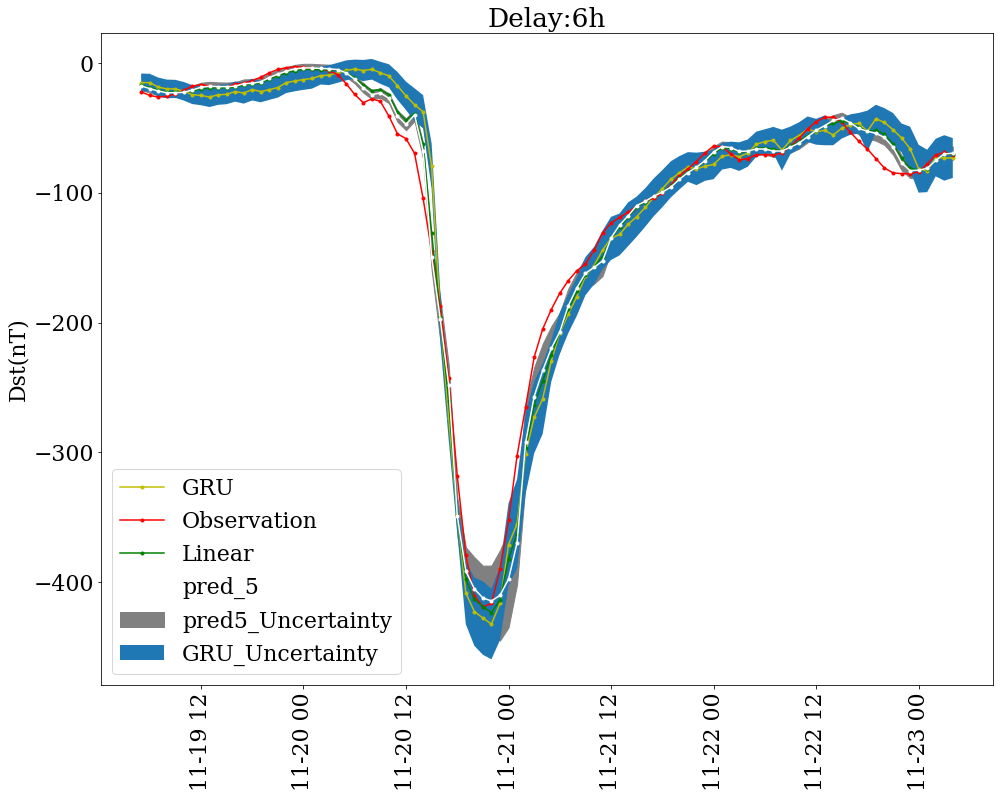

In [20]:
########################### visualize results ################

if visual_flag:
    visualize(delay, date_idx, date_clu, y_pred_t, 
              y_real_t, y_t_clu, y_Per_t, 
              std_Y, std_Y_per, name_clu, 
              color_clu, figname_pred)

### Figure introduction

For the above figure, the x axis is time stamp and y axis is the deterministic Dst index. For a Dst(delay) model,

Yellow line denotes the original GRU model; 
red line denotes real Dst (smoothed);
green line denotes the assimilated Dst (using Linear combination)
white line denotes either the persistence model (when delay=1), or Dst(delay-1) (when delay>1).
The grey bar denotes the uncertainty of either presisitence model or Dst(delay-1) model.
Blue bars denotes the uncertainty of Dst(delay) model.

## Discussion


It is clear that the dDsts are well predicted by the ACCURE method according to the QQ plot. The Dst predictions can be further improved by taking dDst into account via the Linear combination.